In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn  # neural network

# 1. Data preprocessing

In [2]:
data_path = '/home/vboxuser/CLoud_Comp_workspace/lstm_project/initial_training/data/raw/HistoricalData.csv'

df = pd.read_csv(data_path, index_col='Date', parse_dates=True) # make the date column the index and convert it to datetime
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2024-11-22,$141.95,236406200,$145.93,$147.16,$141.10
2024-11-21,$146.67,400946600,$149.35,$152.89,$140.70
2024-11-20,$145.89,309871700,$147.41,$147.56,$142.73
2024-11-19,$147.01,227834900,$141.32,$147.13,$140.99
2024-11-18,$140.15,221866000,$139.50,$141.55,$137.15


In [3]:
print(df.loc['2019-01-22']) 

Close/Last      $3.7193
Volume        660230000
Open            $3.8928
High            $3.9045
Low             $3.6888
Name: 2019-01-22 00:00:00, dtype: object


## 1.1) Feature Engineering

In [4]:
# remove the doller symbols in each column

df["High"] = df["High"].str.replace("$", "")
df["Low"] = df["Low"].str.replace("$", "")
df["Open"] = df["Open"].str.replace("$", "")
df["Close/Last"] = df["Close/Last"].str.replace("$", "")

# convert all vlues to float

df["High"] = df["High"].astype(float)
df["Low"] = df["Low"].astype(float)
df["Open"] = df["Open"].astype(float)
df["Close/Last"] = df["Close/Last"].astype(float)


df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2024-11-22,141.95,236406200,145.93,147.16,141.10
2024-11-21,146.67,400946600,149.35,152.89,140.70
2024-11-20,145.89,309871700,147.41,147.56,142.73
2024-11-19,147.01,227834900,141.32,147.13,140.99
2024-11-18,140.15,221866000,139.50,141.55,137.15


In [5]:
df["High"].dtype # check the data type of the column


dtype('float64')

In [6]:
# take a look at the percentage change from high to low relative to the opening price

df["Range"] = (df["High"] - df["Low"])/ df["Open"] # add a new column to the dataframe
df.pop("Volume") # remove the volume column
df.head()


,Close/Last,Open,High,Low,Range
Date,,,,,
2024-11-22,141.95,145.93,147.16,141.10,0.041527
2024-11-21,146.67,149.35,152.89,140.70,0.081620
2024-11-20,145.89,147.41,147.56,142.73,0.032766
2024-11-19,147.01,141.32,147.13,140.99,0.043447
2024-11-18,140.15,139.50,141.55,137.15,0.031541


<Axes: xlabel='Date'>

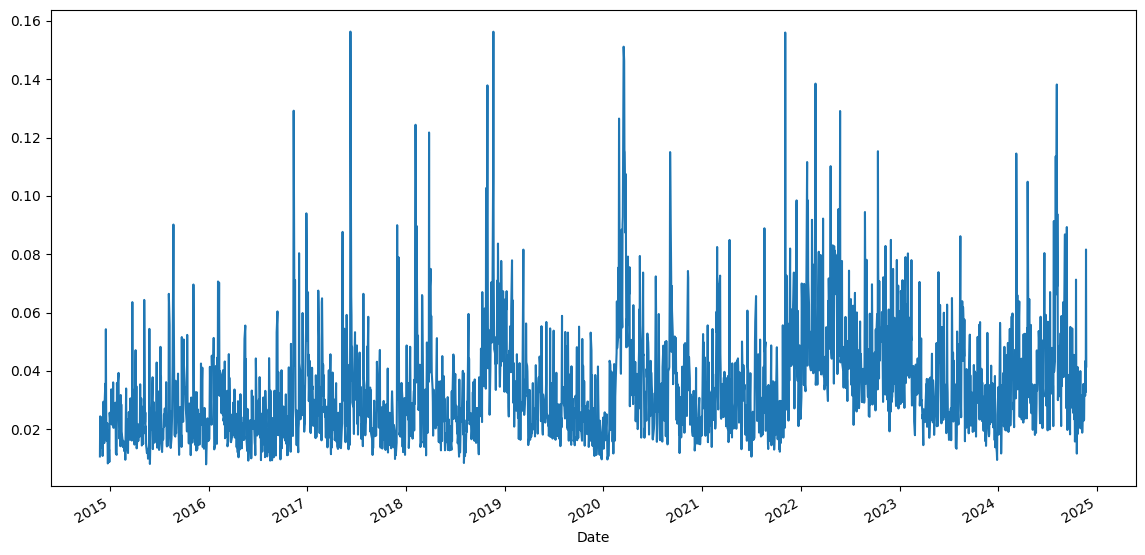

In [7]:
df["Range"].plot(figsize=(14,7)) # plot the range column

<Axes: xlabel='Date'>

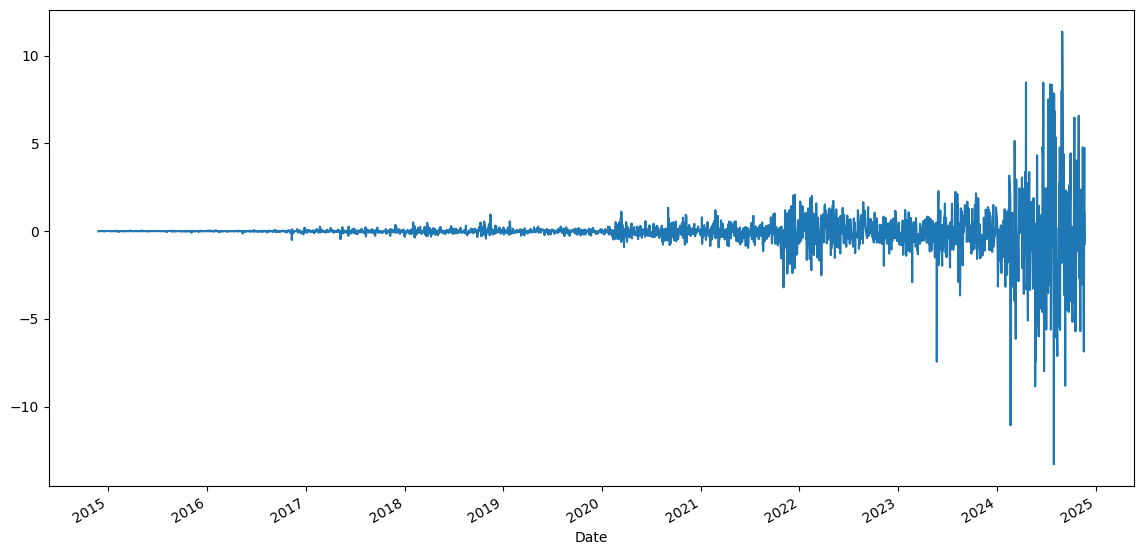

In [8]:
df["abs_change"] = df["Close/Last"].diff() # difference between the closing price of the current day and the previous day
df["abs_change"].plot(figsize=(14,7)) # plot the absolute change column

### We can see early values have very small change in absolute value mainly due to how small the stock prcies were 
 - means lstm model will not see these values 
 - percentage change between the current and previous day

In [9]:
df["Change(%)"] = df["Close/Last"].pct_change() # percentage change in the closing price from the previous day
df.dropna(inplace=True) # remove rows with NaN values
df.head()

,Close/Last,Open,High,Low,Range,abs_change,Change(%)
Date,,,,,,,
2024-11-21,146.67,149.35,152.89,140.70,0.081620,4.72,0.033251
2024-11-20,145.89,147.41,147.56,142.73,0.032766,-0.78,-0.005318
2024-11-19,147.01,141.32,147.13,140.99,0.043447,1.12,0.007677
2024-11-18,140.15,139.50,141.55,137.15,0.031541,-6.86,-0.046663
2024-11-15,141.98,144.87,145.24,140.08,0.035618,1.83,0.013057


<Axes: xlabel='Date'>

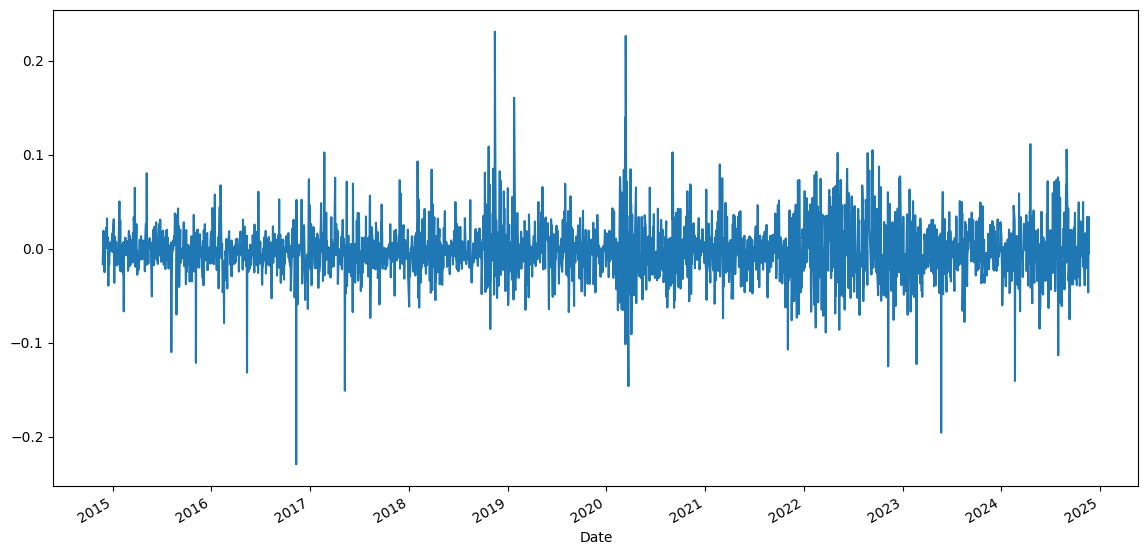

In [ ]:
df["Change(%)"].plot(figsize=(14,7)) # plot the percentage change column
df.pop("abs_change") # remove the absolute change column


### 1.2 Normalising and defining features


In [13]:
# define features and target variable
feature_cols = ["High", "Low", "Open", "Close/Last", "Range", "Change(%)"]
target_col = "Close/Last"

# initialize the MinMaxScaler
scalar = MinMaxScaler(feature_range=(0, 1))

# normalize the data
scaled_features = scalar.fit_transform(df[feature_cols])

scaled_df = pd.DataFrame(scaled_features, columns=feature_cols)
scaled_df.head()    

,High,Low,Open,Close/Last,Range,Change(%)
0,1.000000,0.961862,1.000000,0.985108,0.496430,0.570868
1,0.965027,0.975787,0.986968,0.979852,0.166976,0.487108
2,0.962205,0.963851,0.946060,0.987399,0.239009,0.515329
3,0.925592,0.937511,0.933834,0.941173,0.158719,0.397319
4,0.949804,0.957609,0.969906,0.953505,0.186212,0.527014


In [18]:
# store the scaled data into a new csv file

scaled_df.to_csv('/home/vboxuser/CLoud_Comp_workspace/lstm_project/initial_training/data/preprocessed_data/scaled_nvidia_stock.csv', index=False)